In [77]:
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage import io
from scipy.interpolate import RectBivariateSpline

# from vis import *

254.97 325.05


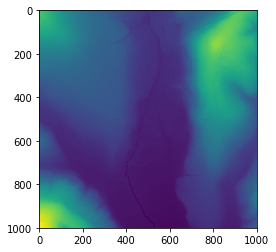

In [4]:
dem = io.imread("/home/klemen/_repo_RVT/RVT_py/test_data/TM1_564_146.tif")

print(dem.min(),dem.max())
plt.imshow(dem)
plt.show()

In [5]:
max_radius = 100
pyramid_scale = 3
max_pyramid_radius = 10
pyramid_levels = 10
pyramid = {}
pyramid[0] = np.arange(max_pyramid_radius)+1
for level in np.arange(pyramid_levels)+1:
    pyramid[level] = (np.arange(7)+4) * pyramid_scale**level
pyramid

{0: array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 1: array([12, 15, 18, 21, 24, 27, 30]),
 2: array([36, 45, 54, 63, 72, 81, 90]),
 3: array([108, 135, 162, 189, 216, 243, 270]),
 4: array([324, 405, 486, 567, 648, 729, 810]),
 5: array([ 972, 1215, 1458, 1701, 1944, 2187, 2430]),
 6: array([2916, 3645, 4374, 5103, 5832, 6561, 7290]),
 7: array([ 8748, 10935, 13122, 15309, 17496, 19683, 21870]),
 8: array([26244, 32805, 39366, 45927, 52488, 59049, 65610]),
 9: array([ 78732,  98415, 118098, 137781, 157464, 177147, 196830]),
 10: array([236196, 295245, 354294, 413343, 472392, 531441, 590490])}

In [62]:
def horizon_shift_vector(num_directions=16, 
                         radius_pixels=10, 
                         min_radius=1,
                         ):
    
    """
    Calculates Sky-View determination movements.

    Parameters
    ----------
    num_directions : number of directions as input
    radius_pixels : radius to consider in pixels (not in meters)
    min_radius : radius to start searching for horizon in pixels (not in meters)


    Returns
    -------
    shift : dict with keys corresponding to the directions of search azimuths rounded to 1 decimal number
            - for each key, a subdict contains a key "shift":
                values for this key is a list of tuples prepared for np.roll - shift along lines and columns
            - the second key is "distance":
                values for this key is a list of search radius used for the computation of the elevation angle 
    """
    
    # Initialize the output dict
    shift = {}

    # Generate angles and corresponding normal shifts in X (columns)
    # and Y (lines) direction
    angles = (2 * np.pi / num_directions) * np.arange(num_directions) 
    x = np.cos(angles)
    y = np.sin(angles)
    angles = np.round(np.degrees(angles), decimals=1)
    
    # Generate a range of radius values in pixels.
    # Make it finer for the selcted scaling.
    # By adding the last constant we make sure that we do not start with
    # point (0,0).
    scale = 3.
    radii = np.arange((radius_pixels-min_radius)*scale+1) / scale + min_radius

    # For each direction compute all possible horizont point position
    # and round them to integers
    for i in range(num_directions):
        x_int = np.round(x[i] * radii, decimals=0)
        y_int = np.round(y[i] * radii, decimals=0)
        # consider only the minimal number of points
        # use the trick with set and complex nuber as the input
        coord_complex = set(x_int + 1j * y_int)
        # to sort proportional with increasing radius, 
        # set has to be converted to numpy array
        shift_pairs = np.array([(k.real, k.imag) for k in coord_complex]).astype(int)
        distance = np.sqrt(np.sum(shift_pairs**2, axis=1))
        sort_index = np.argsort(distance)
        # write for each direction shifts and corresponding distances
        shift[angles[i]] = {
            "shift": [(k[0],k[1]) for k in shift_pairs[sort_index]],
            "distance": distance[sort_index],
            }

    return shift

In [158]:
def horizon_generate_coarse_dem(dem_fine,
                                pyramid_scale,
                                conv_from,
                                conv_to,
                                max_radius,
                                ):

    # get and adjust the array sizes
    in_shape = dem_fine.shape
    n_col_fine = in_shape[1]
    n_lin_fine = in_shape[0]
    # The corner points must fit in the new grid.
    # This is always the case with the left most column or the upper line.
    # But you have to adjust ne number of columns to the right and number of lines below.
    # The final number of columns/lines has to fullfil:
    #     n_coarse = pyramid_scale * n_fine + 1
    # columns
    mod_col = n_col_fine % pyramid_scale
    pad_col = 0
    if mod_col!=1:
        pad_col = np.abs(1 - mod_col)
    # lines
    mod_lin = n_lin_fine % pyramid_scale
    pad_lin = 0
    if mod_lin!=1:
        pad_lin = np.abs(1 - mod_lin)
    dem_fine = np.pad(dem_fine, ((0, pad_lin), (0, pad_col)), mode="edge")
    
    # Once you have data in the shape appropriate for resizing,
    # pad the data to support np.move.
    dem_fine = np.pad(dem_fine, ((-conv_from, conv_to), (-conv_from, conv_to)), mode="edge")
    
    # Convolution
    dem_convolve = np.zeros(dem_fine.shape)
    for i in np.arange(pyramid_scale)+conv_from:
        for j in np.arange(pyramid_scale)+conv_from:
            dem_convolve = dem_convolve + np.roll(dem_fine, (i,j), axis=(0,1))
    # 1) divide by pyramid_scale**2 to provide mean value within the convolution window
    # 2) additional divide by pyramid_scale to account for the chage of resolution
    # (important for the angle computation later on)
    dem_convolve = dem_convolve / pyramid_scale**3
    
    # Consider only the selceted convoluted points according to the scale change.
    # As we select slice's end point make sure to consider at least 1 point more 
    # to the right / below to really include it (Python way of considering end index).
    dem_coarse = dem_convolve[-conv_from:dem_convolve.shape[0]:pyramid_scale, -conv_from:dem_convolve.shape[1]:pyramid_scale]
    
    # final padding to enable searching the horizon over the edge
    dem_coarse = np.pad(dem_coarse, max_radius, mode="edge")

    return dem_coarse

In [167]:
def horizon_generate_pyramids(dem,
                              num_directions=32,
                              max_fine_radius=100,
                              max_pyramid_radius=10,
                              pyramid_scale=3,
                              ):

    # In the levels higher than 1, determin the minimal search distance 
    # and number of search distances.
    # If you have for instance 
    #     pyramid_scale = 3
    #     max_pyramid_radius = 10
    #     num_directions = 8
    # then you have original distances in level 0:
    # 1, 2, 3, ... 9, 10
    # In level 1, your resolution is 3-times coarser.
    # The first pixel that takes that this new resolution,
    # has in original distance value 12 (in coarse resolution 4):
    # 12->4, 15->5, 18->6 ... 27->9, 30->10
    # So you start in the level 1 with tmin_pyramid_radius=4
    # and you search from 4 to 10 distances (n_pyramid_radius=7)
    min_pyramid_radius = int(np.floor(max_pyramid_radius / pyramid_scale)) + 1
    n_pyramid_radius = max_pyramid_radius - min_pyramid_radius + 1

    # get the convolution window indices
    conv_to = int(np.floor(pyramid_scale/2.))
    if (pyramid_scale%2)==0:
        conv_from = 1 - conv_to
    else:
        conv_from = -conv_to

    # initializations
    pyramid_levels = 1
    work = True
    pyramid = {}

    # Determine the number of levels and
    # the last radius to be used in the highest level.
    while work==True:
        _ = max_fine_radius / pyramid_scale**pyramid_levels
        if _ > max_pyramid_radius:
            pyramid_levels = pyramid_levels + 1
        else:
            work = False
            last_radius = np.round(max_fine_radius / pyramid_scale**pyramid_levels, decimals=0)


    # fFll out the pyramid dict with the metadata required for horizont searching.
    for level in np.arange(pyramid_levels+1):
            # the level 0 contains the other min_radius as the rest of levels 
            if level==0:
                min_radius = 1
                dem_fine = np.copy(np.pad(dem, max_pyramid_radius, mode="edge"))
            else:
                min_radius = min_pyramid_radius
                dem_fine = np.copy(dem_coarse)
            # the last level contains the other radius_pixels as the rest of levels
            if level == pyramid_levels:
                max_radius = last_radius
            else:
                max_radius = max_pyramid_radius
            # determine the dict of shifts
            shift = horizon_shift_vector(num_directions, max_radius, min_radius)
            dem_coarse = horizon_generate_coarse_dem(dem_fine, pyramid_scale, conv_from, conv_to, max_pyramid_radius)
            i_lin = np.arange(dem_fine.shape[0])
            i_col = np.arange(dem_fine.shape[1])
#             lin_coarse = np.arange(dem_coarse.shape[0]) * pyramid_scale - conv_from
#             col_coarse = np.arange(dem_coarse.shape[1]) * pyramid_scale - conv_from
            pyramid[level] = {
                "num_directions": num_directions,
                "radius_pixels": max_radius,
                "min_radius": min_radius,
                "shift": shift,
                "dem": dem_fine,
#                 "pad_lin": pad_lin,
#                 "pad_col": pad_col,
                "i_lin": i_lin,
                "i_col": i_col,
#                 "lin_coarse": lin_coarse,
#                 "col_coarse": col_coarse,
                }

    return pyramid

In [168]:
pyramid = horizon_generate_pyramids(dem)
# pyramid

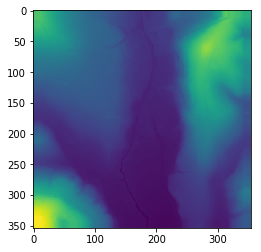

In [169]:
dem_c = horizon_generate_coarse_dem(dem, pyramid_scale, -1, 1, 10)
plt.imshow(dem_c)

In [170]:
print(np.max([i for i in pyramid]))
print(pyramid[3]["dem"].shape)

3
(68, 68)


In [171]:
a=horizon_shift_vector(8, 4, 4)
for i in a.keys():
    print(f"angle {i}")
    for j in a[i]:
        print(f"{j}: {a[i][j]}")

angle 0.0
shift: [(4, 0)]
distance: [4.]
angle 45.0
shift: [(3, 3)]
distance: [4.24264069]
angle 90.0
shift: [(0, 4)]
distance: [4.]
angle 135.0
shift: [(-3, 3)]
distance: [4.24264069]
angle 180.0
shift: [(-4, 0)]
distance: [4.]
angle 225.0
shift: [(-3, -3)]
distance: [4.24264069]
angle 270.0
shift: [(0, -4)]
distance: [4.]
angle 315.0
shift: [(3, -3)]
distance: [4.24264069]


In [172]:
# pyramid[0]["shift"]

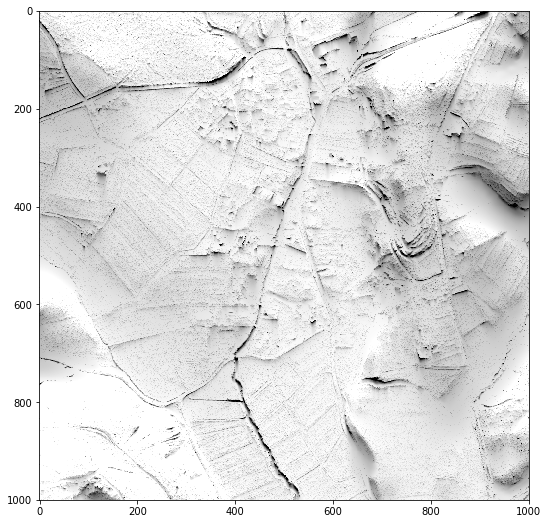

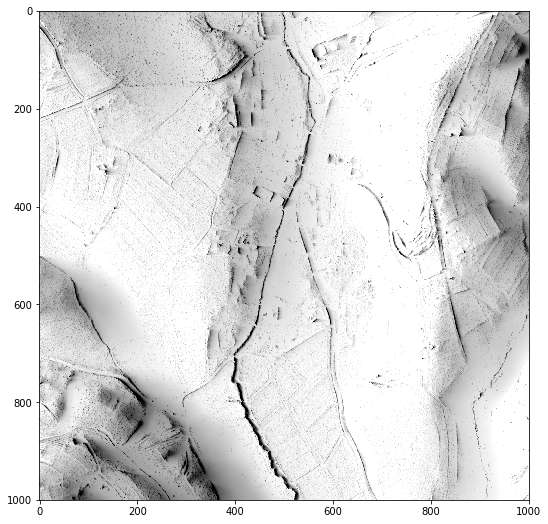

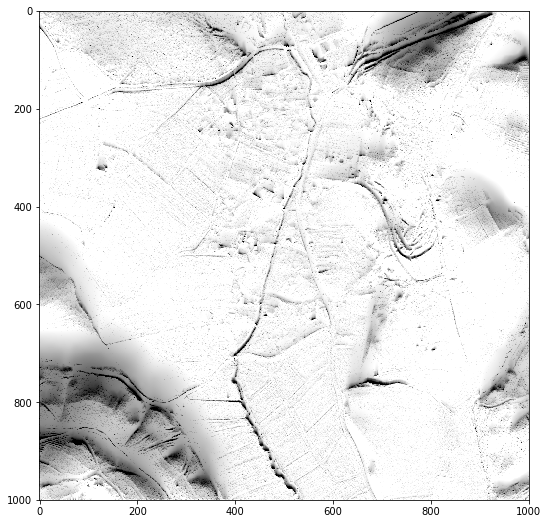

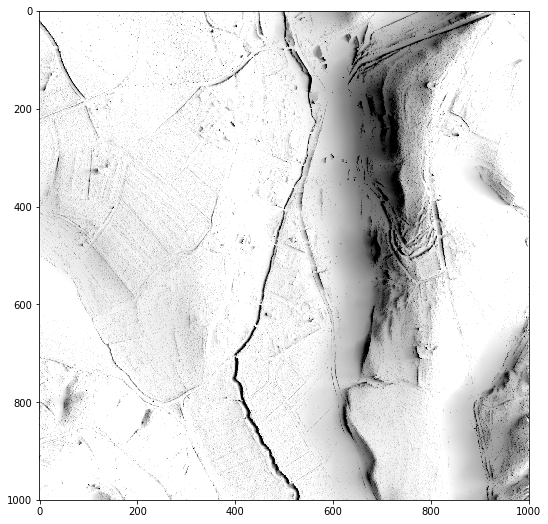

In [183]:
# def sky_view_factor_com_new(height_arr, 
#                             radius_max=10, 
#                             radius_min=1, 
num_directions=4
max_fine_radius=100
#                             compute_svf=True, 
#                             compute_opns=False,
#                             compute_asvf=False, 
#                             a_main_direction=315., 
#                             a_poly_level=4, 
#                             a_min_weight=0.4,
#                             ):
#     """
#     Calculates horizon based visualizations: Sky-view factor, Anisotopic SVF and Openess.

#     Parameters
#     ----------
#     height_arr : elevation (DEM) as 2D numpy array
#     radius_max : maximal search radius in pixels/cells (not in meters)
#     radius_min : minimal search radius in pixels/cells (not in meters), for noise reduction
#     num_directions : number of directions as input
#     compute_svf : if true it computes and outputs svf
#     compute_asvf : if true it computes and outputs asvf
#     compute_opns : if true it computes and outputs opns
#     a_main_direction : main direction of anisotropy
#     a_poly_level : level of polynomial that determines the anisotropy
#     a_min_wight : weight to consider anisotropy:
#                  0 - low anisotropy, 
#                  1 - high  anisotropy (no illumination from the direction opposite the main direction)

#     Returns
#     -------
#     {"svf": svf_out, "asvf": asvf_out, "opns": opns_out} : dictionary
#         svf_out, skyview factor : 2D array of skyview factor.
#         asvf_out, anisotropic skyview factor : 2D array of anisotropic skyview factor.
#         opns_out, openness : 2D array openness (elevation angle of horizon)
#     """

# build DEM pyramids
pyramid = horizon_generate_pyramids(dem,
                                    num_directions=num_directions,
                                    max_fine_radius=max_fine_radius,
                                    max_pyramid_radius=10,
                                    pyramid_scale=3,)
n_levels = np.max([i for i in pyramid])
# get the convolution window indices
conv_to = int(np.floor(pyramid_scale/2.))
if (pyramid_scale%2)==0:
    conv_from = 1 - conv_to
else:
    conv_from = -conv_to

# # compute the vector of movement and corresponding distances
# move = horizon_shift_vector(num_directions=num_directions, radius_pixels=radius_max, min_radius=radius_min)

# # init the output for usual SVF
# if compute_svf:
#     svf_out = np.zeros(height.shape, dtype=np.float32)
# else:
#     svf_out = None
# # init the output for azimuth dependent SVF
# if compute_asvf:
#     asvf_out = np.zeros(height.shape, dtype=np.float32)
#     w_m = a_min_weight
#     w_a = np.deg2rad(a_main_direction)
#     weight = np.arange(num_directions) * (2 * np.pi / num_directions)
#     weight = (1 - w_m) * (np.cos((weight - w_a) / 2)) ** a_poly_level + w_m
# else:
#     asvf_out = None
# # init the output for Openess
# if compute_opns:
#     opns_out = np.zeros(height.shape, dtype=np.float32)
# else:
#     opns_out = None 

# search for horizon in each direction...
for i_dir, direction in enumerate(pyramid[0]["shift"]):
    # reset maximum at each iteration (direction)
    max_slope = np.zeros(pyramid[n_levels]["dem"].shape, dtype=np.float32) - 1000
#     if i_dir==1:
#         break

    for i_level in reversed(range(n_levels+1)):
        height = pyramid[i_level]["dem"]
        move = pyramid[i_level]["shift"]

        # ... and to the search radius
        for i_rad, radius in enumerate(move[direction]["distance"]):
#             print(i_dir,i_level,i_rad)
            # get shift index from move dictionary
            shift_indx = move[direction]["shift"][i_rad]
            # estimate the slope
            _ = (np.roll(height, shift_indx, axis=(0,1)) - height) / radius
            # compare to the previus max slope and keep the larges
            max_slope = np.maximum(max_slope, _)
            
#         plt.imshow(max_slope, cmap="gray")
#         plt.show()
        # resample the max_slope to a lower pyramid level
        if i_level > 0:
            lin_fine = pyramid[i_level-1]["i_lin"] + conv_from + max_pyramid_radius*pyramid_scale
            col_fine = pyramid[i_level-1]["i_col"] + conv_from + max_pyramid_radius*pyramid_scale
            lin_coarse = pyramid[i_level]["i_lin"] * pyramid_scale
            col_coarse = pyramid[i_level]["i_col"] * pyramid_scale
#             print(lin_coarse.shape, col_coarse.shape, max_slope.shape)
            interp_spline = RectBivariateSpline(lin_coarse, col_coarse, max_slope)
            max_slope = interp_spline(lin_fine, col_fine)

#     # convert to angle in radians and compute directional output
    _ = np.arctan(max_slope[max_pyramid_radius:-max_pyramid_radius, max_pyramid_radius:-max_pyramid_radius])
    plt.figure(figsize=(9,9))
    plt.imshow(-_*57., cmap="gray", vmin=-30., vmax=0)
    plt.show()
#     if compute_svf:
#         svf_out = svf_out + (1 - np.sin(np.maximum(_,0)))
#     if compute_asvf:
#         asvf_out = asvf_out + (1 - np.sin(np.maximum(_,0))) * weight[i_dir]
#     if compute_opns:
#         opns_out = opns_out + _

# # cut to original extent and 
# # average the directional output over all directions
# if compute_svf:
#     svf_out = svf_out[radius_max:-radius_max, radius_max:-radius_max] / num_directions
# if compute_asvf:
#     asvf_out = asvf_out[radius_max:-radius_max, radius_max:-radius_max]  / np.sum(weight)
# if compute_opns:
#     opns_out = np.rad2deg(0.5 * np.pi - (opns_out[radius_max:-radius_max, radius_max:-radius_max] / num_directions))

# # return results within dict
# dict_svf_asvf_opns = {"svf": svf_out, "asvf": asvf_out, "opns": opns_out}
# dict_svf_asvf_opns = {k: v for k, v in dict_svf_asvf_opns.items() if v is not None}  # filter out none



In [71]:
tic = time.time()
new = sky_view_factor_com_new(dem, 
                            radius_max=10, 
                            radius_min=1, 
                            num_directions=32,
                            compute_svf=True,
                            compute_asvf=True,
                            compute_opns=True)

toc = time.time()
print(toc-tic)

NameError: name 'sky_view_factor_com_new' is not defined

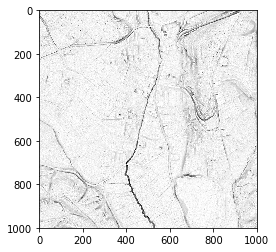

In [24]:
plt.imshow(new["opns"], cmap="gray", vmin=60., vmax=90)


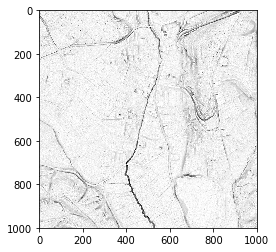

In [25]:
plt.imshow(new["opns"], cmap="gray", vmin=60., vmax=90)

In [32]:
print(np.mean(np.abs(new["svf"]-orig["svf"])))

0.0


In [29]:
new["svf"]

array([[0.9981087 , 0.92859364, 0.9377717 , ..., 0.94786054, 0.9609505 ,
        0.9596426 ],
       [0.97902316, 0.95625174, 0.9557625 , ..., 0.9300823 , 0.9264843 ,
        0.884462  ],
       [0.9980491 , 0.958367  , 0.96161366, ..., 0.9156693 , 0.908821  ,
        0.88075054],
       ...,
       [0.9884285 , 0.9582647 , 0.9680424 , ..., 0.93280613, 0.87745965,
        0.988924  ],
       [0.99396956, 0.9733033 , 0.99441826, ..., 0.9009207 , 0.8985084 ,
        0.9712826 ],
       [0.9835664 , 0.9754426 , 0.9582639 , ..., 0.86386365, 0.8935739 ,
        0.9983164 ]], dtype=float32)

In [33]:
orig["svf"]

array([[0.9977566 , 0.90659755, 0.91785383, ..., 0.9359067 , 0.9560784 ,
        0.9585856 ],
       [0.9755626 , 0.9419798 , 0.94070256, ..., 0.9271652 , 0.928661  ,
        0.89653075],
       [0.9972658 , 0.9427529 , 0.947971  , ..., 0.9178736 , 0.915398  ,
        0.891163  ],
       ...,
       [0.98977476, 0.94936854, 0.95746076, ..., 0.9461427 , 0.8996018 ,
        0.9887797 ],
       [0.994617  , 0.97085977, 0.99332136, ..., 0.9179895 , 0.9153528 ,
        0.9674824 ],
       [0.98414063, 0.97587293, 0.9601372 , ..., 0.8874974 , 0.9125484 ,
        0.99841315]], dtype=float32)

In [36]:
np.arange(10)*81

array([  0,  81, 162, 243, 324, 405, 486, 567, 648, 729])

In [51]:
pyramid

{0: array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 1: array([12, 15, 18, 21, 24, 27, 30]),
 2: array([36, 45, 54, 63, 72, 81, 90]),
 3: array([108, 135, 162, 189, 216, 243, 270]),
 4: array([324, 405, 486, 567, 648, 729, 810]),
 5: array([ 972, 1215, 1458, 1701, 1944, 2187, 2430]),
 6: array([2916, 3645, 4374, 5103, 5832, 6561, 7290]),
 7: array([ 8748, 10935, 13122, 15309, 17496, 19683, 21870])}